# Data Cleansing with R

In [1]:
library(dplyr)
library(ggplot2)
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggExtra
Warning message:
"package 'ggExtra' was built under R version 3.5.2"Loading required package: naniar
Warning message:
"package 'naniar' was built under R version 3.5.2"Loading required package: mvoutlier
Warning message:
"package 'mvoutlier' was built under R version 3.5.2"Loading required package: sgeostat
Warning message:
"package 'sgeostat' was built under R version 3.5.2"sROC 0.1-2 loaded
Loading required package: MissMech
Warning message:
"package 'MissMech' was built under R version 3.5.2"Loading required package: mice
Warning message:
"package 'mice' was built under R version 3.5.2"Loading required package: lattice

Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind

Loading required package: MatchIt
War

In [2]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [5]:
### load data

ffWNV4 <- read.csv(file="C:/Users/Chen/Project/data/ffWNV4.csv")
head(ffWNV4)

ID,Date,Month_Yr,Address,Block,Latitude,Longitude,Street,CULEX_ERRATICUS,CULEX_PIPIENS,...,RA45,PT45_gt50,RA45_2,WnvPresentB,PrecipTotal2i.x,RA45i,PT45_gt50i,RA45_2i,PT45_gt50_2,PT45_gt50_2i
1,2007-05-29,2007-05,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,41.86711,-87.65422,W ROOSEVELT,0,0,...,NA,NA,NA,0,2,13,0,11,NA,0
2,2007-05-29,2007-05,"1100 South Peoria Street, Chicago, IL 60608, USA",11,41.86229,-87.64886,S PEORIA ST,0,0,...,NA,NA,NA,0,2,19,1,13,NA,0
3,2007-05-29,2007-05,"1100 West Chicago Avenue, Chicago, IL 60642, USA",11,41.89628,-87.65523,W CHICAGO,0,0,...,NA,NA,NA,0,2,11,0,10,NA,0
4,2007-05-29,2007-05,"1500 North Long Avenue, Chicago, IL 60651, USA",15,41.90765,-87.76089,N LONG AVE,0,0,...,NA,NA,NA,0,2,12,0,12,NA,0
5,2007-05-29,2007-05,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,41.92160,-87.66645,W WEBSTER AVE,0,0,...,NA,NA,NA,0,2,17,0,17,NA,0
6,2007-05-29,2007-05,"1700 West 95th Street, Chicago, IL 60643, USA",17,41.72085,-87.66601,W 95TH ST,0,0,...,NA,NA,NA,0,2,12,0,9,NA,1


# Outliers

## Univariate Outliers

as.data.frame(colnames(ffWNV4))

In [6]:
str(ffWNV4)

'data.frame':	4616 obs. of  72 variables:
 $ ID                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Date                  : Factor w/ 95 levels "2007-05-29","2007-06-05",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Month_Yr              : Factor w/ 20 levels "2007-05","2007-06",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Address               : Factor w/ 138 levels "1000 East 67th Street, Chicago, IL 60637, USA",..: 6 8 10 14 16 19 26 28 29 32 ...
 $ Block                 : int  11 11 11 15 15 17 21 22 22 22 ...
 $ Latitude              : num  41.9 41.9 41.9 41.9 41.9 ...
 $ Longitude             : num  -87.7 -87.6 -87.7 -87.8 -87.7 ...
 $ Street                : Factor w/ 128 levels "  W ARMITAGE AVENUE",..: 124 75 108 27 128 103 42 18 88 102 ...
 $ CULEX_ERRATICUS       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ CULEX_PIPIENS         : int  0 0 0 0 0 0 0 0 0 1 ...
 $ CULEX_PIPIENS_RESTUANS: int  1 0 0 0 0 0 1 2 1 0 ...
 $ CULEX_RESTUANS        : int  2 1 1 1 2 3 0 3 1 5 ...
 $ CULEX_SALINARIUS      : int  0 0 0 0 0 0

In [5]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(ffWNV4,threshold=1.5))

ID,Block,Latitude,Longitude,CULEX_ERRATICUS,CULEX_PIPIENS,CULEX_PIPIENS_RESTUANS,CULEX_RESTUANS,CULEX_SALINARIUS,CULEX_TARSALIS,...,RA45,PT45_gt50,RA45_2,WnvPresentB,PrecipTotal2i.x,RA45i,PT45_gt50i,RA45_2i,PT45_gt50_2,PT45_gt50_2i
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,0,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,1


In [7]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(ffWNV4,threshold=2.0))

ID,Block,Latitude,Longitude,CULEX_ERRATICUS,CULEX_PIPIENS,CULEX_PIPIENS_RESTUANS,CULEX_RESTUANS,CULEX_SALINARIUS,CULEX_TARSALIS,...,RA45,PT45_gt50,RA45_2,WnvPresentB,PrecipTotal2i.x,RA45i,PT45_gt50i,RA45_2i,PT45_gt50_2,PT45_gt50_2i
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,0,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,0
0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,0,0,0,1,0,NA,1


In [8]:
colnames(ffWNV4)

[1] "ID"                     "Date"                   "Month_Yr"              
 [4] "Address"                "Block"                  "Latitude"              
 [7] "Longitude"              "Street"                 "CULEX_ERRATICUS"       
[10] "CULEX_PIPIENS"          "CULEX_PIPIENS_RESTUANS" "CULEX_RESTUANS"        
[13] "CULEX_SALINARIUS"       "CULEX_TARSALIS"         "CULEX_TERRITANS"       
[16] "WnvPresent"             "Month"                  "Tmax"                  
[19] "Tmin"                   "Tavg"                   "Depart"                
[22] "DewPoint"               "Heat"                   "Cool"                  
[25] "Sunrise"                "Sunset"                 "PrecipTotal"           
[28] "ResultSpeed"            "ResultDir"              "AvgSpeed"              
[31] "BR"                     "DZ"                     "FG"                    
[34] "HZ"                     "RA"                     "TS"                    
[37] "TSRA"                   "VCTS"                   "Tmax2"                 
[40] "Tmin2"                  "Tavg2"                  "WetBulb2"              
[43] "Heat2"                  "PrecipTotal2"           "StnPressure2"          
[46] "ResultDir2"             "AvgSpeed2"              "BR2"                   
[49] "DZ2"                    "FG2"                    "HZ2"                   
[52] "RA2"                    "TS2"                    "TSRA2"                 
[55] "VCTS2"                  "ParasiticIn."           "Influenza."            
[58] "Spray"                  "Year"                   "Season_code"           
[61] "TrapM"                  "Snow_Fall"              "RA45"                  
[64] "PT45_gt50"              "RA45_2"                 "WnvPresentB"           
[67] "PrecipTotal2i.x"        "RA45i"                  "PT45_gt50i"            
[70] "RA45_2i"                "PT45_gt50_2"            "PT45_gt50_2i"

In [7]:
var1<-c( 'Month', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal' ,'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Tmax2', 'Tmin2', 'Tavg2', 'WetBulb2', 'Heat2', 'PrecipTotal2', 'StnPressure2', 'ResultDir2', 'AvgSpeed2', 'ParasiticIn.', 'Influenza.', 'RA45', 'RA45_2' )

In [8]:
pdf('out1.pdf')
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(ffWNV4[var1])) {
    boxplot(ffWNV4[[v]],main=v)
}
par(mfrow=c(1,1))

dev.off()

png 
  2

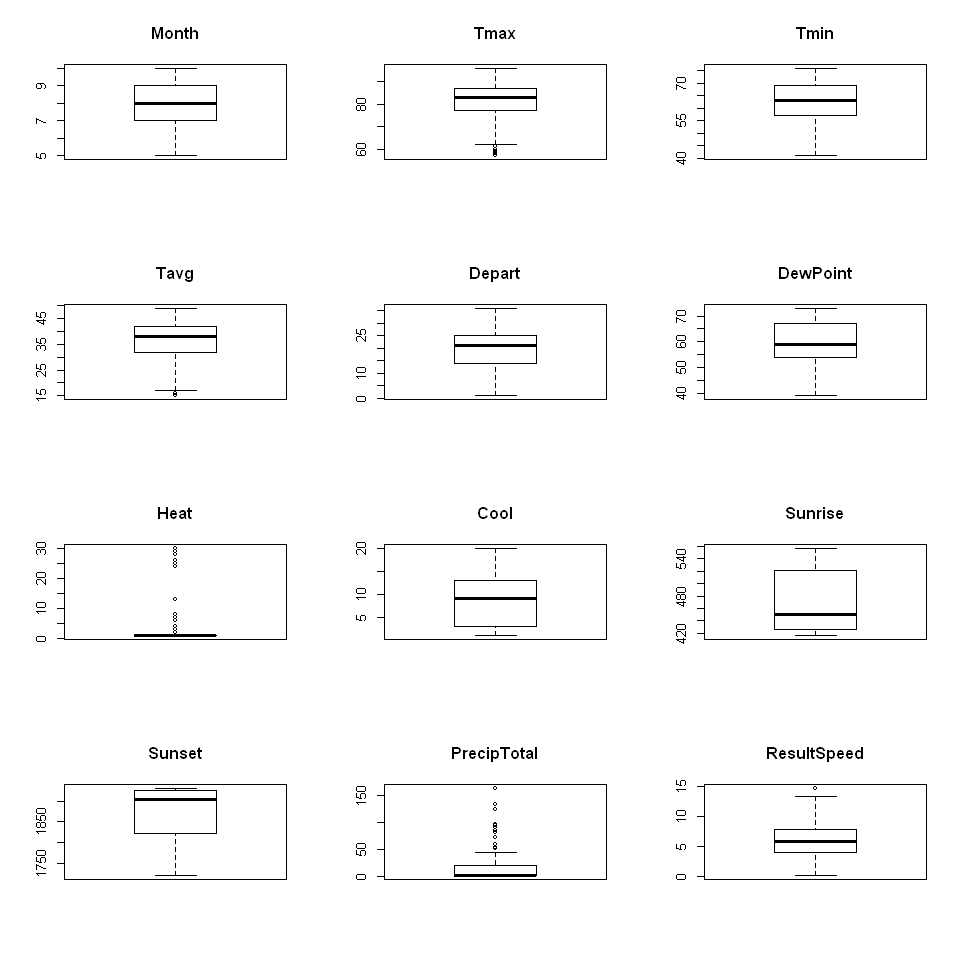

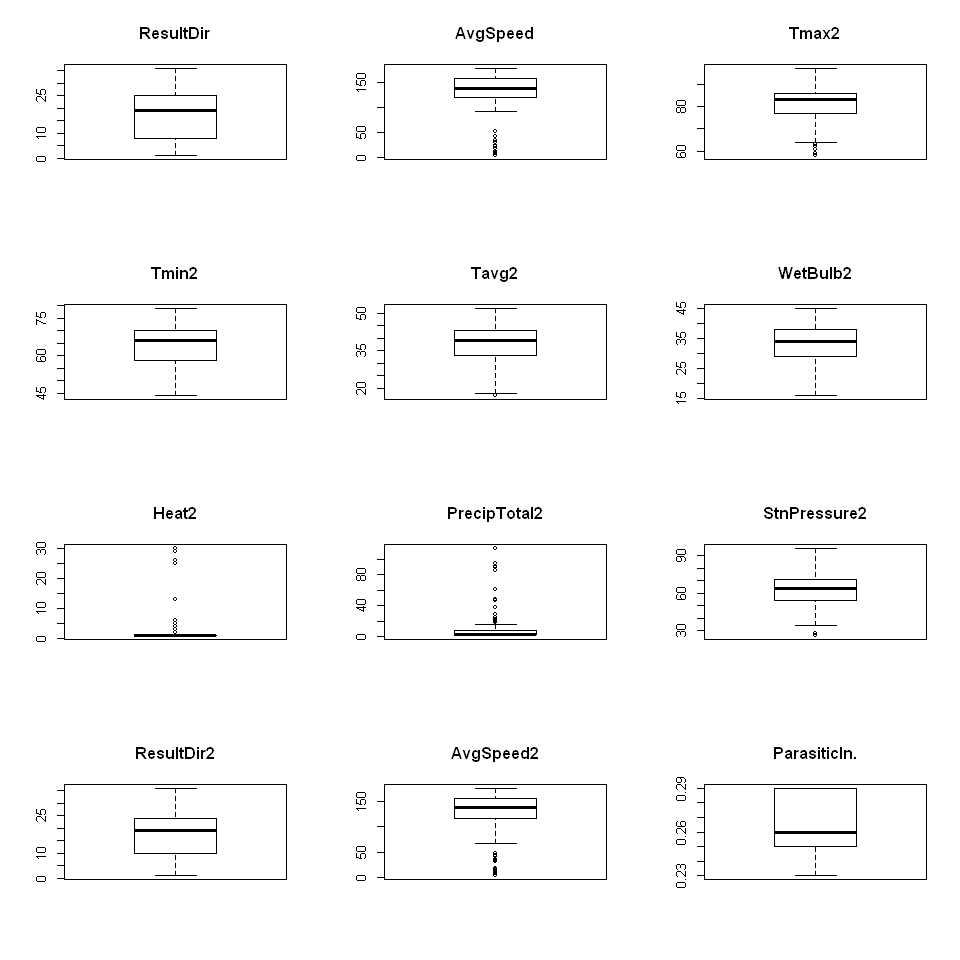

png 
  2

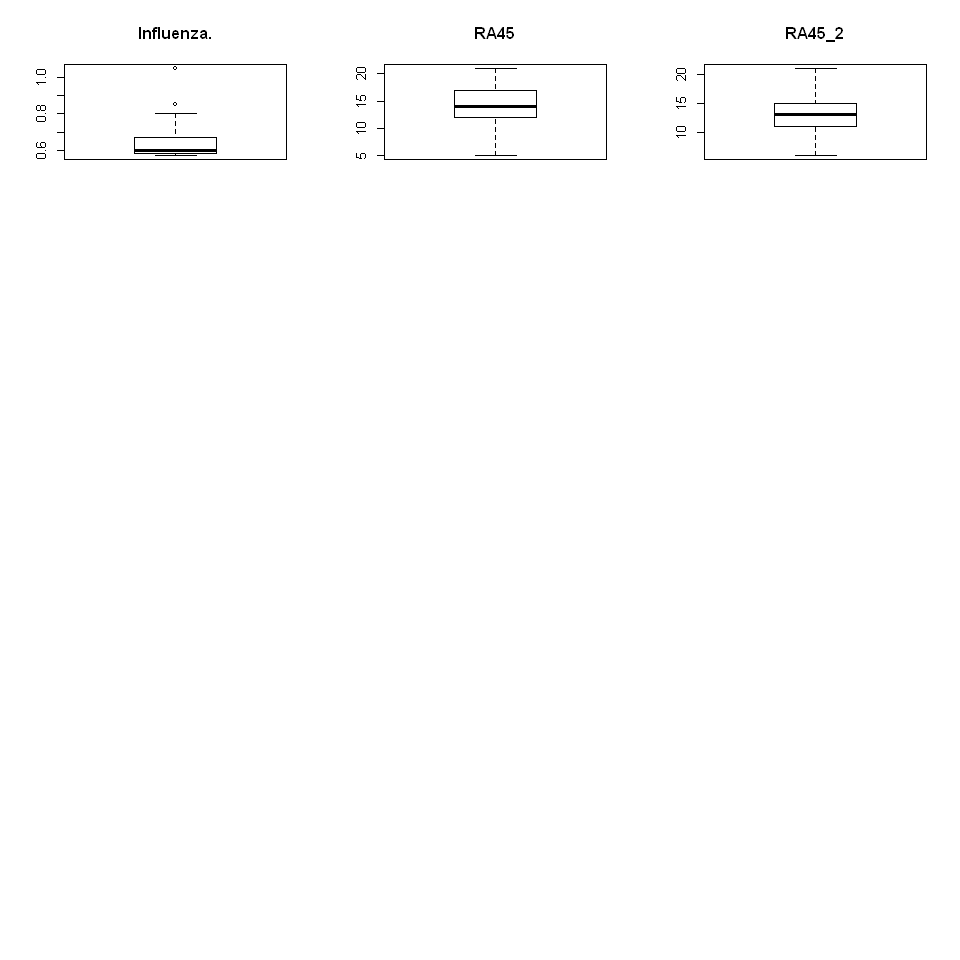

In [33]:
## Visual determination of univariate outliers using boxplots 

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(ffWNV4[var1])) {
    boxplot(ffWNV4[[v]],main=v)
}
par(mfrow=c(1,1))



In [17]:
## Visual determination of univariate outliers using scatter plots 

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(ffWNV4[var1])) {
    scatter.smooth(ffWNV4[[v]] ~ ffWNV4$Date, main=v, xlab="Index",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2))
}
par(mfrow=c(1,1))

dev.copy(png, filename="out2.jpg");
dev.off ();

png 
  3

png 
  2

# Missingness

In [75]:
head(missingMatrix(ffWNV4))

ID,Date,Month_Yr,Address,Block,Latitude,Longitude,Street,CULEX_ERRATICUS,CULEX_PIPIENS,...,ParasiticIn.,Influenza.,Spray,Year,Season_code,TrapM,Snow_Fall,RA45,PT45_gt50,RA45_2
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


ERROR: Error in object[[i]]: object of type 'closure' is not subsettable


## Missing values visualization

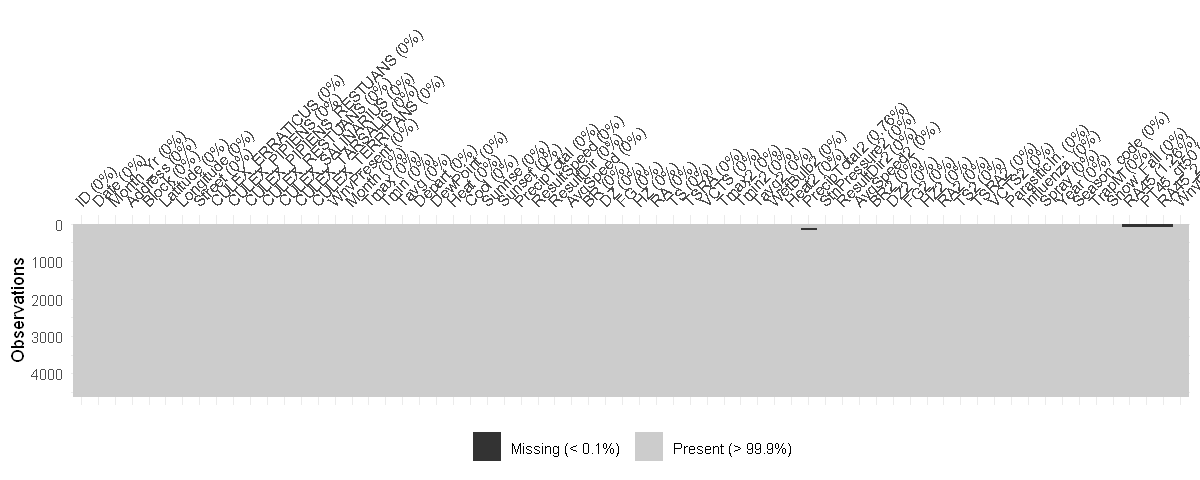

In [4]:
options(repr.plot.width = 10, repr.plot.height = 4)
vis_miss(ffWNV4)

In [ ]:
בדיקת הערכים החסרים בהשוואה למשתנה אחר

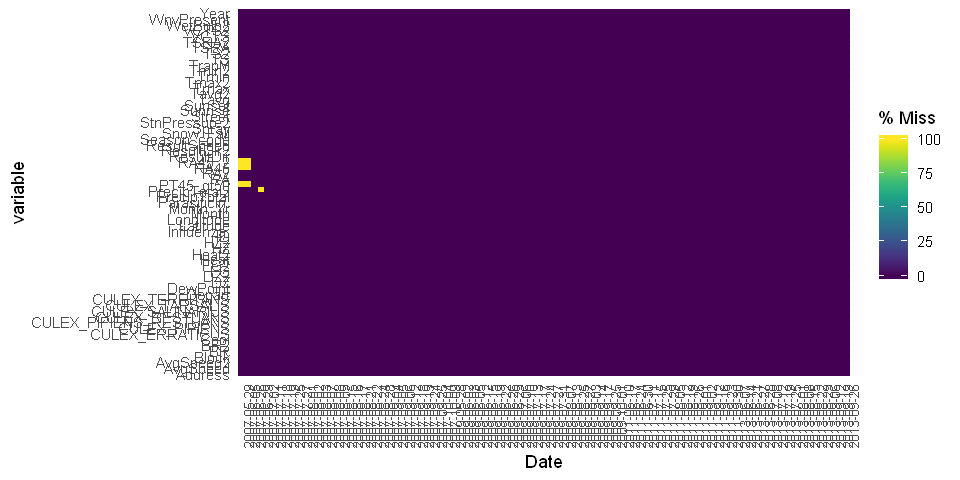

In [57]:
# require(naniar)
options(repr.plot.width = 8, repr.plot.height = 4)
gg_miss_fct(x=ffWNV4, fct=Date) + 
theme(axis.text.x = element_text(angle=90, size=8))

In [89]:
var2<-c( 'PrecipTotal' , 'PrecipTotal2', 'RA45', 'RA45_2','PT45_gt50','Date' )

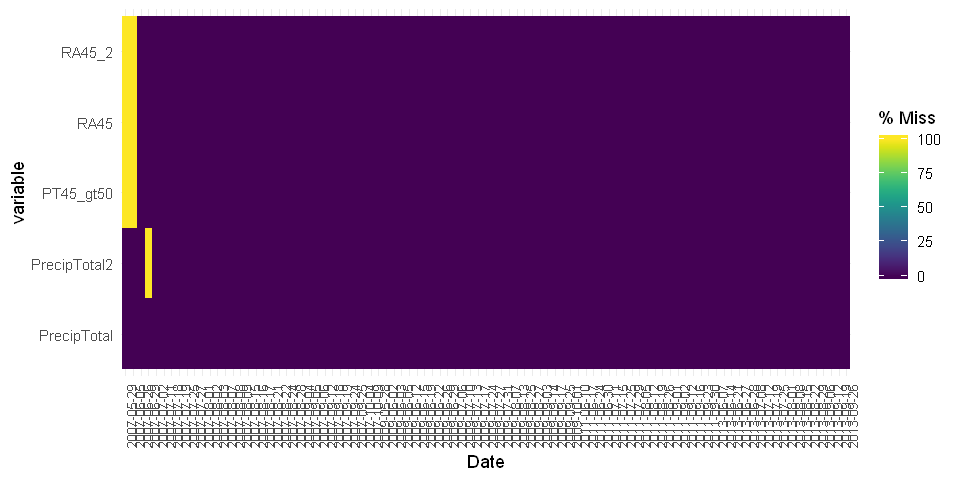

In [90]:
options(repr.plot.width = 8, repr.plot.height = 4)
gg_miss_fct(x=ffWNV4[var2], fct=Date) + 
theme(axis.text.x = element_text(angle=90, size=8))

In [ ]:
פונקציה GGPLOT


## Determinate the Missingness Generation Mechanism
 
There are three mechanisms that generate Missing values:
 
1. Missing Completely at Random (MCAR)
2. Missing at Random (MAR)
3. Missing not at Random (MNAR)
 
We will investigate the missingness mechanisms using different techniques.


In [ ]:
RA45	PT45_gt50	RA45_2

In [64]:
grep("RA45", colnames(ffWNV4))

[1] 63 65

In [65]:
grep("RA45_2", colnames(ffWNV4))

[1] 65

In [66]:
grep("PT45_gt50", colnames(ffWNV4))

[1] 64

In [63]:
grep("PrecipTotal2",colnames(ffWNV4))

[1] 44

In [ ]:
נשתמש במיסמאטצ פונקציה קיימת
נבדוק רק איפה שיש חוסר

In [7]:
# require(MissMech)
ffWNV4m <- ffWNV4[,c(44,63,64,65)]
miss1 <- TestMCARNormality(data=ffWNV4m)
miss1

Call:
TestMCARNormality(data = ffWNV4m)

Number of Patterns:  3 

Total number of cases used in the analysis:  4616 

 Pattern(s) used:
          PrecipTotal2   RA45   PT45_gt50   RA45_2   Number of cases
group.1              1     NA          NA       NA                58
group.2              1      1           1        1              4523
group.3             NA      1           1        1                35


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  8.146594e-130 

    Either the test of multivariate normality or homoscedasticity (or both) is rejected.
    Provided that normality can be assumed, the hypothesis of MCAR is 
    rejected at 0.05 significance level. 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0 

    Hypothesis of MCAR is rejected at  0.05 significance level.
    The multivariate normality test is i

In [ ]:
עושה שתי בדיקות
אחד של נורמליזציה של הנתונים
אם יש מובהקות לא נורמלי
השארת האפס היא שהנתונים לא נורמליים
ולכן בודקים במבן לא פרמטרי
במבחן הלא פרמטרי לא ניתן לדחות חוסר באקראיות גמורה 

In [8]:
### Impute missing values

miss1 <- TestMCARNormality(data=ffWNV4m, , del.lesscases = 1, imputation.number = 10)
summary(miss1)



Number of imputation:  10 

Number of Patterns:  3 

Total number of cases used in the analysis:  4616 

 Pattern(s) used:
          PrecipTotal2   RA45   PT45_gt50   RA45_2   Number of cases
group.1              1     NA          NA       NA                58
group.2              1      1           1        1              4523
group.3             NA      1           1        1                35


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  8.146594e-130 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0 


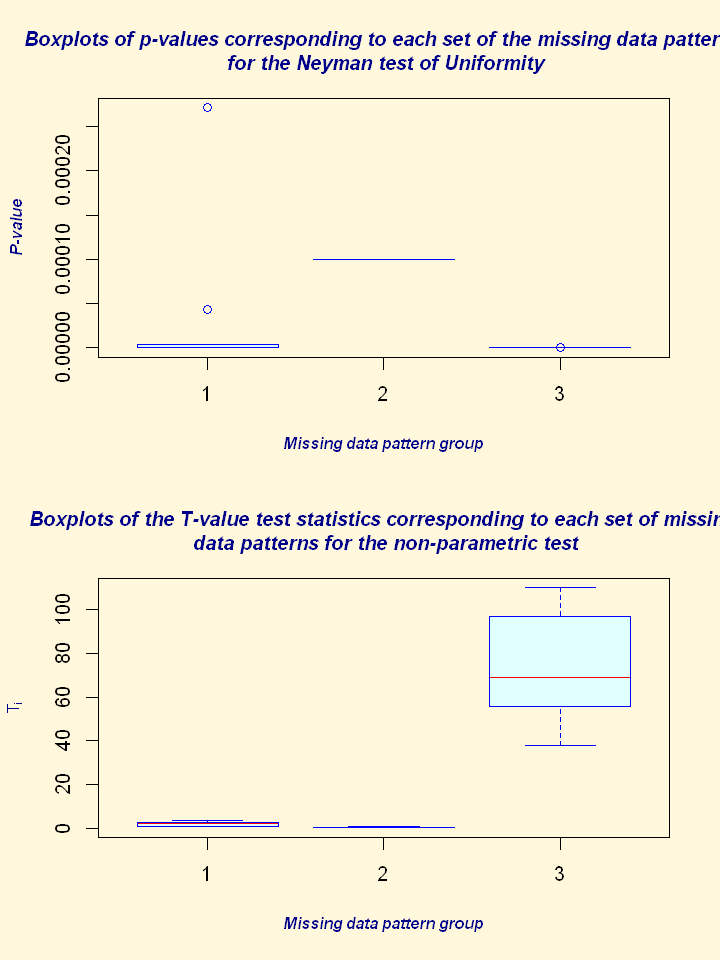

In [9]:
options(repr.plot.width = 6, repr.plot.height = 8)
boxplot(miss1)

In [10]:
summary(miss1$imputed.data)

ffWNV4.imp <- data.frame(miss1$imputed.data)
idx <- miss1$caseorder

head(ffWNV4.imp)
dim(ffWNV4.imp)

  PrecipTotal2         RA45         PT45_gt50          RA45_2  
 Min.   :  1.00   Min.   : 5.00   Min.   :0.0000   Min.   : 6  
 1st Qu.:  2.00   1st Qu.:12.00   1st Qu.:1.0000   1st Qu.:11  
 Median :  2.00   Median :14.00   Median :1.0000   Median :13  
 Mean   : 13.41   Mean   :14.19   Mean   :0.9976   Mean   :13  
 3rd Qu.:  8.00   3rd Qu.:17.00   3rd Qu.:1.0000   3rd Qu.:15  
 Max.   :114.00   Max.   :21.00   Max.   :1.0012   Max.   :21  

PrecipTotal2,RA45,PT45_gt50,RA45_2
2,13.03357,0.9984417,11.004319
2,19.00057,1.0000003,13.000038
2,11.03334,0.9984417,10.004209
2,12.94621,0.9999137,12.944727
2,17.54408,0.9992643,17.530443
2,12.77192,0.9964068,9.704497


[1] 4616    4

In [11]:
summary(ffWNV4[,c(44,63,64,65)])

  PrecipTotal2         RA45         PT45_gt50          RA45_2  
 Min.   :  1.00   Min.   : 5.00   Min.   :0.0000   Min.   : 6  
 1st Qu.:  2.00   1st Qu.:12.00   1st Qu.:1.0000   1st Qu.:11  
 Median :  2.00   Median :14.00   Median :1.0000   Median :13  
 Mean   : 13.34   Mean   :14.19   Mean   :0.9976   Mean   :13  
 3rd Qu.:  8.00   3rd Qu.:17.00   3rd Qu.:1.0000   3rd Qu.:15  
 Max.   :114.00   Max.   :21.00   Max.   :1.0000   Max.   :21  
 NA's   :35       NA's   :58      NA's   :58       NA's   :58  

In [97]:
write.csv(ffWNV4.imp, file="C:/Users/Chen/Project/data/ffWNV4.imp.csv", row.names =F)